# Fused Ridge Model Training & Evaluation Pipeline

### This notebook performs training and evaluation of ridge and fused ridge models on a gene-specific protein dataset.
### It includes data loading, preprocessing, model fitting, performance evaluation, and interpretability analysis via structural mapping.

In [27]:
# --- Imports and Utilities ---
import os, re, time, json, csv, joblib,sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors


from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV, RidgeCV, LogisticRegressionCV
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve

from utility_files.data_loading import *
from utility_files.model_training import train_ridge_model
from utility_files.fused_ridge_gpu import FusedRidge
from utility_files.data_preprocessing import *
from utility_files.distance_processing import *
from utility_files.evaluation import *

## Initialize by gene name

In [2]:
results= []
# --- Configuration ---
gene_name = 'rpsL'
genes_of_interest = gene_name.split(',')
seed_everything(42)  # Reproducibility

## Required Data files

In [ ]:
# --- Load Metadata and Mutation Annotations ---
gene_details = pd.read_csv("data/all_drug_genes_locations.csv")
filtered_df = gene_details[gene_details['gene_name'].str.contains('|'.join(genes_of_interest), case=False, na=False)]
drug_name = filtered_df['drug_full'].values[0].upper()
uniprot = filtered_df['Uniprot'].values[0]
entry = filtered_df['Entry'].values[0]
print(f"Target Gene: {gene_name}, Associated Drug: {drug_name}")


Target Gene: rpsL, Associated Drug: STREPTOMYCIN


In [ ]:
variants_df = load_variants("data/mutations_with_one_letter_all.csv")
distmap_path = f"data/distmaps/{uniprot}/{entry}"
dist_map = DistanceMap.from_file(distmap_path)

In [8]:
# Load mutation annotations and extract positions associated with resistance
variants_df[['aa_ref', 'aa_pos', 'aa_change']] = variants_df['mutation'].str.extract(r'p\.([A-Za-z]+)(\d+)([A-Za-z]+)')
variants_df = variants_df[(variants_df['gene'].str.contains(gene_name, case=False, na=False)) &
                          (variants_df['confidence'].str.contains("Assoc w R", case=False, na=False))]
variants_df.dropna(subset=['aa_pos'], inplace=True)
total_actual_positives = len(np.unique(variants_df['aa_pos']))
print(f"Total confirmed resistance positions: {total_actual_positives}")


Total confirmed resistance positions: 2


## Load training data

In [10]:
# --- Load Feature Matrix and Labels ---
X, y = load_feature_matrix_and_labels(gene_name)
dist_map = DistanceMap.from_file(f"data/distmaps/{uniprot}/{entry}")
# Binary encode phenotype labels
y_encoded = encode_labels(y)

Loading feature matrix and labels for rpsL from disk.


## Train on non-unique data

In [11]:
# --- Split the data ---
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# --- Baseline Models: Lasso, Ridge, Logistic Regression ---
lasso = LassoCV(max_iter=10000, cv=5, random_state=42, alphas=[0.001, 0.01, 0.1, 1, 10, 100]).fit(X_train, y_train)
print("Lasso AUC:", roc_auc_score(y_test, lasso.predict(X_test)))

ridge = RidgeCV(alphas=[0.001, 0.01, 0.1, 1, 10]).fit(X_train, y_train)
print("Ridge AUC:", roc_auc_score(y_test, ridge.predict(X_test)))

logistic_model = LogisticRegressionCV(cv=3, scoring="roc_auc", max_iter=5000,
                                      Cs=[1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100], class_weight="balanced")
logistic_model.fit(X_train, y_train)
print("Logistic Regression AUC:", roc_auc_score(y_test, logistic_model.predict(X_test)))

Lasso AUC: 0.6899577100835552
Ridge AUC: 0.6900914668852309
Logistic Regression AUC: 0.6896005509641873


## Train on unique, de-duplicated data

In [21]:
# --- Deduplicate Data ---
X_unique, original_indices = drop_identical_columns(X)
X_unique_rows, row_selection_indices = drop_identical_sequences(X_unique)
filtered_labels, [X_filtered] = filter_nan_labels(y[row_selection_indices], X_unique_rows)
y_encoded = encode_labels(filtered_labels)
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)
X_train, X_test, y_train, y_test = np.array(X_train),np.array(X_test),np.array(y_train),np.array(y_test) 

# --- Train Ridge on Deduplicated Data ---
ridge_model, ridge_score, ridge_auc, ridge_mse = train_ridge_model(X_train, y_train, X_test, y_test)
initial_coef = ridge_model.coef_


## precision -recall from ridge

In [22]:
# --- Variant Prioritization Based on Ridge ---
original_indices = np.array(original_indices)
percentiles = np.arange(50, 100, 5)
best_results = find_best_percentile(ridge_model, original_indices, gene_name, variants_df, percentiles,
                                     compute_feature_importance, compute_precision_recall)
ridge_features = compute_feature_importance(ridge_model, original_indices, gene_name, best_results['best_percentile'])
print("Ridge Precision/Recall:", compute_precision_recall(variants_df, gene_name, ridge_features))

Ridge Precision/Recall: (100.0, 50.0)


## Fused Ridge training module

In [41]:
# --- Subset Features using 3D Distance Map ---
subset_distance_matrix, valid_original_indices, subset_coef, valid_positions = process_distance_matrix(dist_map, original_indices, initial_coef)
scale_param = compute_scale_param(dist_map.dist_matrix)
X_train_subset = X_train[:, np.isin(original_indices, valid_original_indices)]
X_test_subset = X_test[:, np.isin(original_indices, valid_original_indices)]
# --- Load Hyperparameters and Train Fused Ridge ---
optimizer_name='enhanced'
with open("data/best_params.json", 'r') as f:
    best_params = json.load(f)[gene_name][optimizer_name]

In [24]:
fused_ridge = FusedRidge(
    initial_coef=subset_coef,
    optimizer='enhanced',
    alpha=best_params['alpha'],
    lambda_fuse=best_params['lambda_fuse'],
    scale_param=scale_param,
    learning_rate=best_params['learning_rate'],
    decay_type=best_params['decay_type'],
    beta=best_params['beta'],
    clip_value=0.9,
    max_iter=2000,
    early_stopping=True,
    tolerance=1e-6,
    n_iter_no_change=50,
    dimension_threshold=10
)
fused_ridge.set_distance_matrix(subset_distance_matrix)

start_time = time.time()
fused_ridge.fit(X_train_subset, y_train)
end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f}s. Converged: {fused_ridge.converged}")

Iterative optimization applied.
Stopped after reaching max_iter (2000). Final loss: 1.064976213317218
Training completed in 0.37s. Converged: False


In [25]:
# --- Evaluate Fused Ridge ---
y_pred = fused_ridge.predict(X_test_subset)
print("Fused Ridge AUC:", roc_auc_score(y_test, y_pred))
print("Fused Ridge MSE:", mean_squared_error(y_test, y_pred))

# --- Feature Attribution: Fused Ridge ---
best_results = find_best_percentile(fused_ridge, valid_original_indices, gene_name, variants_df, percentiles,
                                     compute_feature_importance, compute_precision_recall)
top_features = compute_feature_importance(fused_ridge, valid_original_indices, gene_name, best_results['best_percentile'])
print("Fused Precision/Recall:", compute_precision_recall(variants_df, gene_name, top_features))

Fused Ridge AUC: 1.0
Fused Ridge MSE: 0.20518883310444283
Fused Precision/Recall: (40.0, 100.0)


In [28]:
y_pred_test = fused_ridge.predict(X_test_subset)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_pred_test)
optimal_threshold = calculate_optimal_threshold(fpr, tpr, thresholds)
classification_metrics = calculate_classification_metrics(y_test, y_pred_test,optimal_threshold)
regression_metrics = calculate_regression_metrics(y_test, y_pred_test)
print(f"Fused Lasso AUC: {classification_metrics['roc_auc_score']}")
print(f"Classification Metrics: {classification_metrics}")
print(f"Regression Metrics: {regression_metrics}")

Fused Lasso AUC: 1.0
Classification Metrics: {'sensitivity': 1.0, 'specificity': 1.0, 'f1_score': 1.0, 'roc_auc_score': 1.0}
Regression Metrics: {'r2': 0.07665025103000733, 'mae': 0.3723672882731906, 'rmse': 0.4529777401864719, 'medae': 0.5392342673674153}


## Visualization of 3D Structure Influence and Optimization Trajectory

In [30]:
fused_coefficients = fused_ridge.coef_
coef_to_mutant_mapping = dict(zip(original_indices, fused_coefficients))
# Print the coefficient, mutant position, and its index in the array
for index, (mutant_pos, coef) in enumerate(coef_to_mutant_mapping.items()):
    print(f"Coefficient position {index}: Mutant position {mutant_pos}: Coefficient {coef}")

Coefficient position 0: Mutant position 0: Coefficient -0.0003522840829925764
Coefficient position 1: Mutant position 2: Coefficient -0.03087734645354247
Coefficient position 2: Mutant position 17: Coefficient 0.0032209576334396566
Coefficient position 3: Mutant position 35: Coefficient 0.004484088431163836
Coefficient position 4: Mutant position 43: Coefficient 0.46076573263258463
Coefficient position 5: Mutant position 55: Coefficient 0.0020801803853918053
Coefficient position 6: Mutant position 58: Coefficient 0.008017953571794143
Coefficient position 7: Mutant position 64: Coefficient 0.42671266681426107
Coefficient position 8: Mutant position 65: Coefficient 0.0017608719427558448
Coefficient position 9: Mutant position 70: Coefficient -0.03061537651294706
Coefficient position 10: Mutant position 71: Coefficient 0.0016801148681832496
Coefficient position 11: Mutant position 76: Coefficient 0.43051219256365403
Coefficient position 12: Mutant position 86: Coefficient 0.50306732992030

#### visualize the 3D spatial relationships between residue positions within a protein using a distance map derived from its structure. Do the most predictive residues (from fused ridge) form local neighborhoods in 3D space?

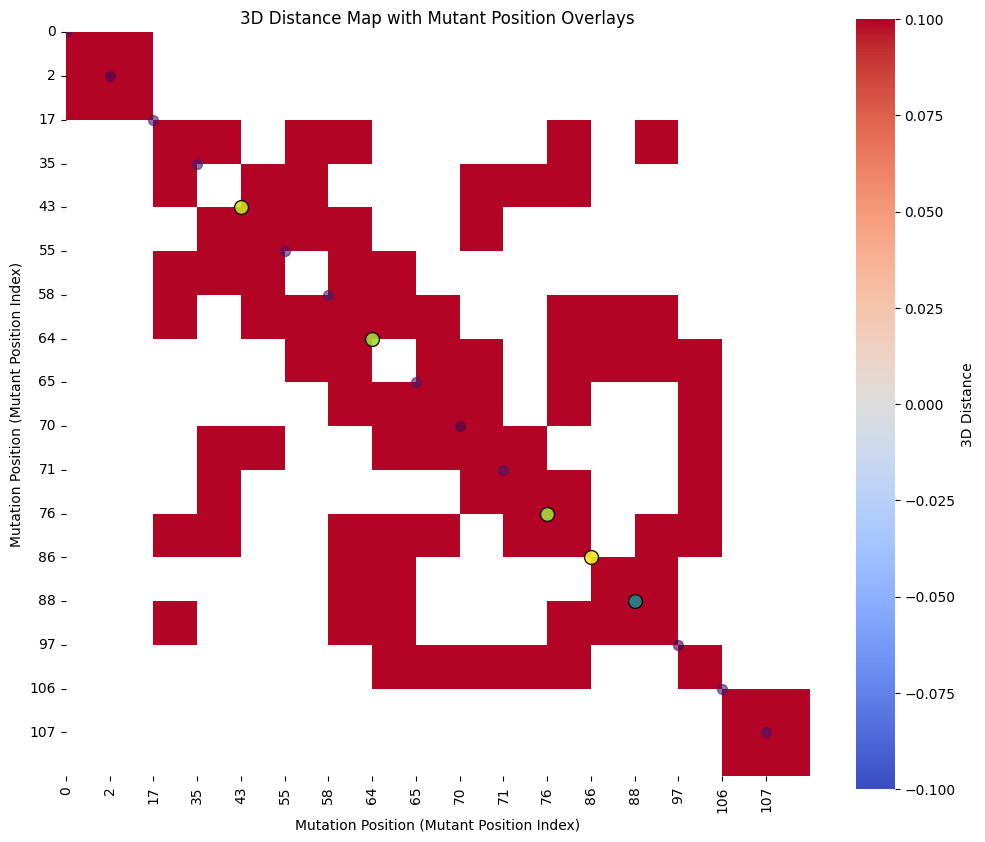

In [33]:
# Select only important indices that are also in `valid_original_indices`
filtered_top_features = [idx for idx in fused_original_indices_above_cutoff if idx in valid_original_indices]
# Mask self-distances if they are set to zero
mask = subset_distance_matrix == 0

# Plot the 3D distance heatmap with mutant positions on the axes
plt.figure(figsize=(12, 10))
sns.heatmap(subset_distance_matrix, mask=mask, cmap='coolwarm', square=True, cbar_kws={'label': '3D Distance'})

# Set tick positions and labels to match mutant positions
plt.xticks(ticks=np.arange(len(valid_original_indices)), labels=valid_original_indices, rotation=90)
plt.yticks(ticks=np.arange(len(valid_original_indices)), labels=valid_original_indices, rotation=0)

# Normalize coefficients for plotting
min_coef, max_coef = min(coef_to_mutant_mapping.values()), max(coef_to_mutant_mapping.values())
normalized_coef = {mutant_pos: (coef - min_coef) / (max_coef - min_coef) for mutant_pos, coef in coef_to_mutant_mapping.items()}

# Overlay coefficients based on mutant positions
for mutant_pos, coef in coef_to_mutant_mapping.items():
    if mutant_pos in valid_original_indices:
        # Find the index corresponding to the mutant position
        idx = np.where(valid_original_indices == mutant_pos)[0][0]

        # Use a larger marker for top features
        if mutant_pos in filtered_top_features:
            plt.scatter(idx, idx, color=plt.cm.viridis(normalized_coef[mutant_pos]), s=100, edgecolor='k', alpha=0.9)
        else:
            plt.scatter(idx, idx, color=plt.cm.viridis(normalized_coef[mutant_pos]), s=50, alpha=0.6)

plt.title("3D Distance Map with Mutant Position Overlays")
plt.xlabel("Mutation Position (Mutant Position Index)")
plt.ylabel("Mutation Position (Mutant Position Index)")
plt.show()


In [34]:
# Check if there are any NaN values in the distance matrix - debug step
has_nan = np.isnan(subset_distance_matrix).any()
print(f"Does the matrix contain NaN values? {has_nan}")

# Count the number of NaN values in the matrix
nan_count = np.isnan(subset_distance_matrix).sum()
print(f"Number of NaN values in the matrix: {nan_count}")

# Optionally, check the proportion of NaN values
total_elements = subset_distance_matrix.size
nan_proportion = nan_count / total_elements
print(f"Proportion of NaN values: {nan_proportion:.4f}")

zero_count = np.sum(subset_distance_matrix == 0)
print(f"Number of zero values: {zero_count}")
print(f"Proportion of zero values: {zero_count / subset_distance_matrix.size:.4f}")

print(f"Min value: {np.min(subset_distance_matrix)}")
print(f"Max value: {np.max(subset_distance_matrix)}")
print(f"Mean value: {np.mean(subset_distance_matrix)}")


inf_count = np.sum(np.isinf(subset_distance_matrix))
total_elements = subset_distance_matrix.size
print(f"Number of inf values: {inf_count}")
print(f"Proportion of inf values: {inf_count / total_elements:.4f}")


Does the matrix contain NaN values? False
Number of NaN values in the matrix: 0
Proportion of NaN values: 0.0000
Number of zero values: 0
Proportion of zero values: 0.0000
Min value: 1.32472298991147
Max value: inf
Mean value: inf
Number of inf values: 199
Proportion of inf values: 0.6886


0.0


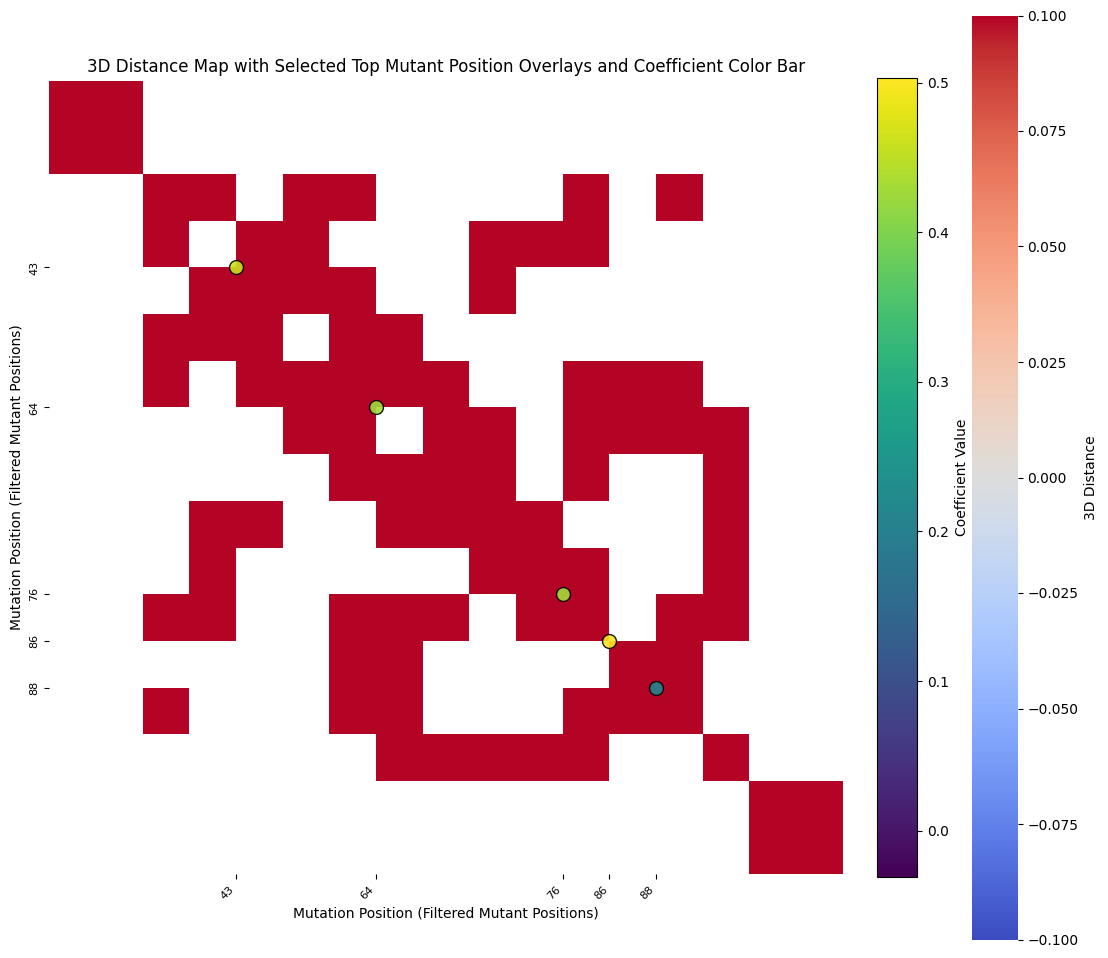

In [35]:
# Identify and mask the diagonal (self-distances, which are 0) to prevent them from dominating the color scale
mask = subset_distance_matrix == 0
print(np.sum(mask) / mask.size)  # Print the proportion of masked (self-distance) elements

# Create a new figure for the heatmap visualization
plt.figure(figsize=(14, 12))

# Plot the full 3D distance matrix using a diverging color scale, masking out the self-distances
sns.heatmap(
    subset_distance_matrix, 
    mask=mask, 
    cmap='coolwarm', 
    square=True, 
    cbar_kws={'label': '3D Distance'}  # Label for color bar
)

# Extract only the mutant positions that were selected as important (filtered_top_features)
top_positions = [pos for pos in valid_original_indices if pos in filtered_top_features]
# Find corresponding indices in the distance matrix
top_indices = [np.where(valid_original_indices == pos)[0][0] for pos in top_positions]

# Reduce visual clutter: for rpsL show all positions, for others only every 5th to avoid overlap
if gene_name == 'rpsL':
    selected_top_positions = top_positions
    selected_top_indices = top_indices
else:
    selected_top_positions = top_positions[::5]
    selected_top_indices = top_indices[::5]

# Set axis ticks and labels based on selected top features
plt.xticks(
    ticks=selected_top_indices, 
    labels=selected_top_positions, 
    rotation=45, 
    ha="right", 
    fontsize=8
)
plt.yticks(
    ticks=selected_top_indices, 
    labels=selected_top_positions, 
    fontsize=8
)

# Normalize model coefficients to [0, 1] for color mapping
min_coef, max_coef = fused_ridge.coef_.min(), fused_ridge.coef_.max()
normalized_coef = {
    mutant_pos: (coef - min_coef) / (max_coef - min_coef) 
    for mutant_pos, coef in coef_to_mutant_mapping.items()
}

# Create a ScalarMappable for mapping coefficients to colors
coef_cmap = cm.viridis
coef_norm = mcolors.Normalize(vmin=min_coef, vmax=max_coef)
sm = cm.ScalarMappable(cmap=coef_cmap, norm=coef_norm)
sm.set_array([])

# Overlay each top feature’s coefficient as a colored dot on the heatmap diagonal
for mutant_pos, coef in coef_to_mutant_mapping.items():
    indices = np.where(valid_original_indices == mutant_pos)[0]
    if mutant_pos in filtered_top_features and len(indices) > 0:
        idx = indices[0]
        plt.scatter(
            idx, idx, 
            color=coef_cmap(normalized_coef[mutant_pos]), 
            s=100, 
            edgecolor='k', 
            alpha=0.9
        )

# Add a color bar to indicate the magnitude of fused ridge coefficients
cbar = plt.colorbar(sm, ax=plt.gca(), orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label('Coefficient Value')

# Add figure title and axis labels
plt.title("3D Distance Map with Selected Top Mutant Position Overlays and Coefficient Color Bar")
plt.xlabel("Mutation Position (Filtered Mutant Positions)")
plt.ylabel("Mutation Position (Filtered Mutant Positions)")

# Show the final plot
plt.show()


In [ ]:

aa_positions_for_gene = get_aa_positions_by_gene(variants_df, gene_name)
print(f"List of amino acid positions for {gene_name}: {aa_positions_for_gene}")

Sorted Neighborhoods by Weighted Influence:
   mutation_index  position  neighbors_count  cumulative_sum  cumulative_avg  \
4              88        13                6        1.585000        0.264167   
2              76        11                9        1.058980        0.117664   
3              64         7                8        1.097415        0.137177   
0              86        12                4        1.151267        0.287817   
1              43         4                5        0.444733        0.088947   

   weighted_influence  
4            0.774548  
2            0.508267  
3            0.464388  
0            0.415186  
1            0.340471  


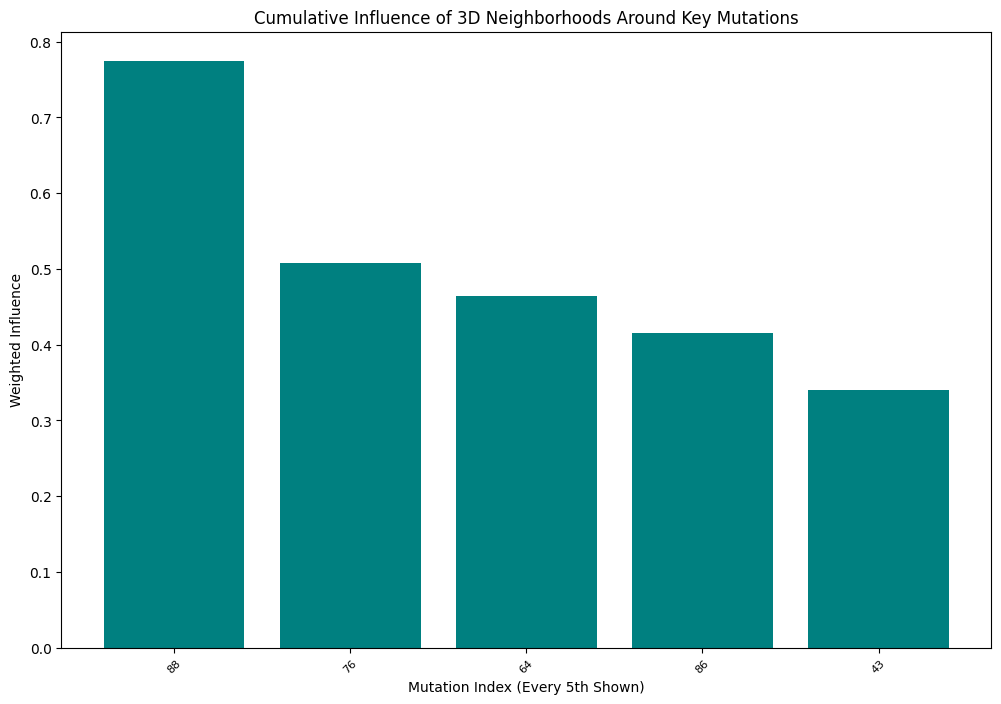

In [36]:
# Parameters
distance_threshold = 5  # Adjust this threshold based on your 3D structure
neighborhood_influences = []

# Loop through each key mutation
for key_index in filtered_top_features:  # Only considering top features
    key_position = np.where(valid_original_indices == key_index)[0][0]
    
    # Identify neighbors within the distance threshold
    neighbors = np.where(subset_distance_matrix[key_position] <= distance_threshold)[0]
    
    # Aggregate influence: Sum or average the coefficients of neighboring mutations
    neighborhood_coef_sum = np.sum([fused_ridge.coef_[neighbor] for neighbor in neighbors])
    neighborhood_coef_avg = np.mean([fused_ridge.coef_[neighbor] for neighbor in neighbors])
    
    # Optional: Weighted influence based on 1 / 3D distance
    distances = subset_distance_matrix[key_position, neighbors]
    weighted_influence = np.sum(fused_ridge.coef_[neighbors] / (distances + 1e-5))  # Adding small epsilon to avoid div by zero
    
    # Store cumulative influence score
    neighborhood_influences.append({
        'mutation_index': key_index,
        'position': key_position,
        'neighbors_count': len(neighbors),
        'cumulative_sum': neighborhood_coef_sum,
        'cumulative_avg': neighborhood_coef_avg,
        'weighted_influence': weighted_influence
    })

# Convert to a structured array or DataFrame for easy sorting and analysis
neighborhood_df = pd.DataFrame(neighborhood_influences)

# Sort by cumulative influence or weighted influence to rank neighborhoods
sorted_neighborhoods = neighborhood_df.sort_values(by='weighted_influence', ascending=False)

# Print the sorted DataFrame
print("Sorted Neighborhoods by Weighted Influence:")
print(sorted_neighborhoods)

# Visualization of cumulative influence across neighborhoods
plt.figure(figsize=(12, 8))
plt.bar(sorted_neighborhoods['mutation_index'].astype(str), sorted_neighborhoods['weighted_influence'], color='teal')

if gene_name=='rpsL':
        
    # Display only every 5th x-axis label
    plt.xticks(
        ticks=np.arange(len(sorted_neighborhoods)), 
        labels=sorted_neighborhoods['mutation_index'].astype(str), 
        rotation=45, 
        fontsize=8
    )
else:

    # Display only every 5th x-axis label
    plt.xticks(
        ticks=np.arange(len(sorted_neighborhoods))[::5], 
        labels=sorted_neighborhoods['mutation_index'].astype(str).iloc[::5], 
        rotation=45, 
        fontsize=8
    )
plt.xlabel("Mutation Index (Every 5th Shown)")
plt.ylabel("Weighted Influence")
plt.title("Cumulative Influence of 3D Neighborhoods Around Key Mutations")
plt.show()


In [37]:
# Check which top features are missing in valid_original_indices
missing_features = [idx for idx in filtered_top_features if idx not in valid_original_indices]

print("Missing top features (not in valid_original_indices):", missing_features)


Missing top features (not in valid_original_indices): []


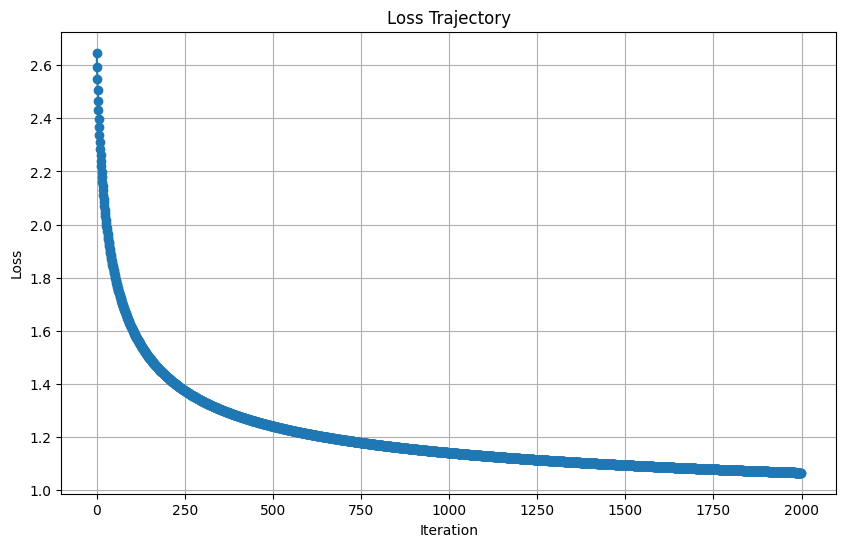

In [38]:
# Plot loss trajectory
plot_loss_trajectory(fused_ridge.history['loss'], gene_name)

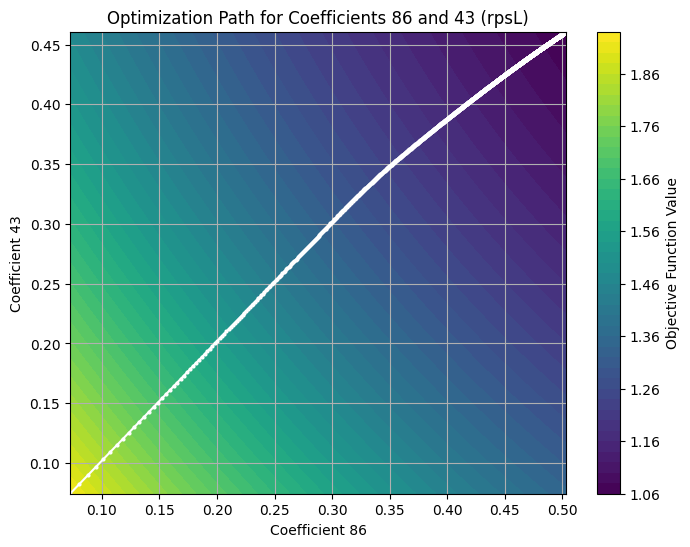

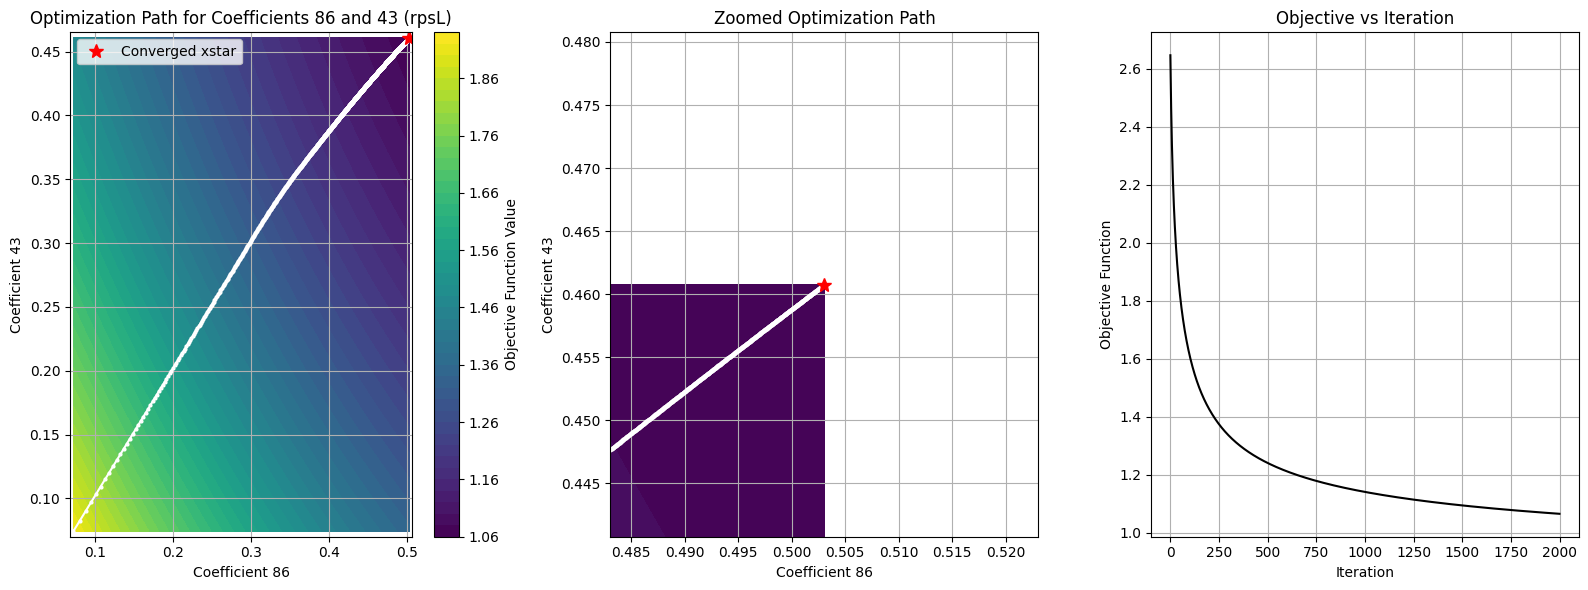

In [39]:
#plot optimization trajectory of two imp features

# Select two feature indices to visualize
idx1 =fused_original_indices_above_cutoff[0]
idx2 = fused_original_indices_above_cutoff[1]

plot_optimization_path_2d(fused_ridge, idx1, idx2, gene_name,valid_original_indices)


# Generate three-panel optimization plot
optimization_plots(
    fused_ridge, 
    original_idx1=fused_original_indices_above_cutoff[0], 
    original_idx2=fused_original_indices_above_cutoff[1],
    gene_name=gene_name,
    valid_indices=valid_original_indices)